<a href="https://colab.research.google.com/github/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/blob/main/notebooks/Human_Emotion_Detection_using_Transfer_Learning_with_EfficientNetB4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Emotion Detection using EfficientNet and Transfer Learning

In this project, we focus on detecting human emotions from images, specifically identifying three emotions: **sad**, **angry**, and **happy**. The model is built using **Transfer Learning** and **fine-tuning** with the **EfficientNet** architecture, which is known for its high performance and efficiency in image classification tasks.

## What is Transfer Learning?

Transfer learning leverages a pre-trained model, such as EfficientNet, which has been trained on a large dataset (e.g., ImageNet). By fine-tuning the pre-trained model on our smaller, specific dataset, we can save time and computational resources while still achieving high accuracy.

## Why EfficientNet?

EfficientNet is a state-of-the-art convolutional neural network (CNN) model that efficiently balances model size and accuracy. Its architecture scales well, making it ideal for tasks like emotion detection where computational efficiency is important.

## EfficientNet Architecture Overview

EfficientNet is a family of models that were introduced by Google researchers in 2019. The key feature of EfficientNet is its use of **compound scaling**, which allows it to scale the model's width, depth, and resolution in a balanced manner. This results in models that are both accurate and efficient.

### Key Features:
1. **Compound Scaling:** EfficientNet uses a compound scaling method that uniformly scales all dimensions of the model (depth, width, and resolution) rather than scaling them individually. This scaling approach helps in achieving better performance without unnecessarily increasing computational complexity.
   
2. **Efficient Building Blocks:** EfficientNet utilizes a novel **mobile inverted bottleneck convolution (MBConv)** block that improves efficiency without sacrificing accuracy. This block is designed to reduce the number of parameters and computations while maintaining high performance.

3. **Depthwise Convolutions:** The use of depthwise separable convolutions helps reduce the computational cost by applying convolutions separately to each input channel.

4. **Performance and Efficiency:** EfficientNet models are known for achieving state-of-the-art performance on image classification tasks with fewer parameters and lower computational costs compared to other models like ResNet and Inception.

### Variants of EfficientNet:
EfficientNet comes in several variants, denoted as EfficientNet-B0 to EfficientNet-B7. These variants differ in size, with EfficientNet-B0 being the smallest and most computationally efficient, while EfficientNet-B7 is the largest and most accurate model.

For this project, we will likely use EfficientNet-B0 or B3, depending on the trade-off between speed and accuracy required for human emotion detection.

## Approach

1. **Preprocessing:** Images will be preprocessed to fit the input requirements of EfficientNet.
2. **Transfer Learning:** We'll load the pre-trained EfficientNet model and modify the final layers for emotion classification.
3. **Fine-tuning:** The model will be fine-tuned on the emotion dataset, adjusting the weights to improve its accuracy for this specific task.
4. **Evaluation:** The model will be evaluated based on its accuracy and ability to correctly classify emotions.

By using EfficientNet and transfer learning, this project aims to build a highly accurate and efficient model for emotion detection in images.


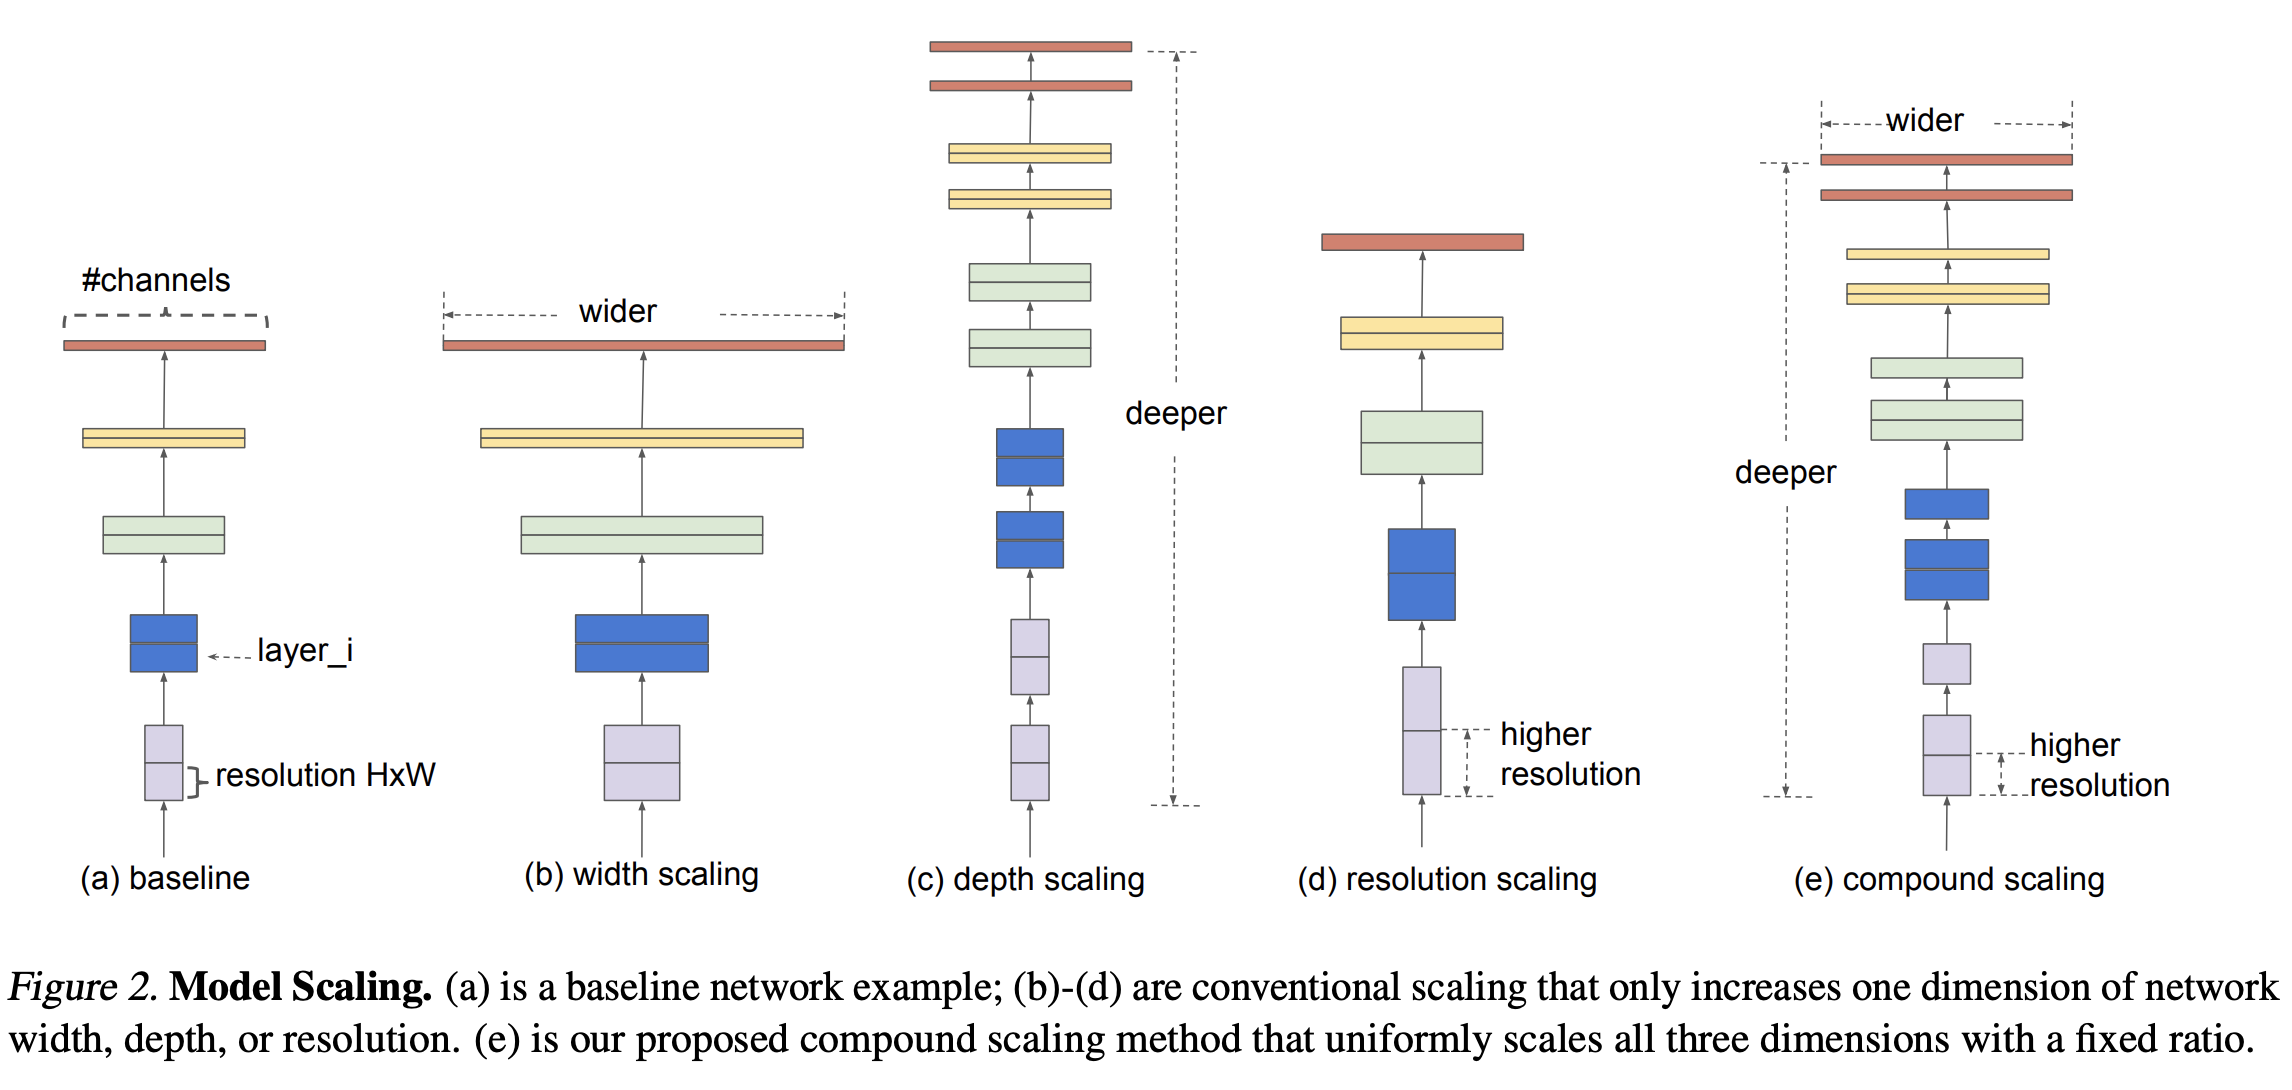

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive
import requests

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
!pip install -q kaggle

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

cp: cannot stat 'kaggle.json': No such file or directory


In [4]:
!chmod 600/root/.kaggle/kaggle.json

chmod: missing operand after ‘600/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.


In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:16<00:00, 19.6MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [6]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/


In [7]:
train_directory = "/content/4/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/4/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ["angry" , "happy" , "sad"]

CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

In [8]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [9]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_directory,
    labels='inferred', # inferred from the directory structure
    label_mode='categorical',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"],CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [10]:
training_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset = val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

# Detailed Explanation of the Model Architecture

In this section, we describe the overall architecture used for emotion detection, where the backbone of the model is EfficientNetB4, a state-of-the-art pre-trained convolutional neural network (CNN). This architecture is adapted for a custom emotion classification task, leveraging transfer learning for optimal performance.

## Backbone Model (EfficientNetB4)

The backbone of the model is based on **EfficientNetB4**, which is a powerful and efficient deep learning architecture. EfficientNetB4 is part of the EfficientNet family and provides a good balance between model accuracy and computational efficiency. By using a pre-trained model, we benefit from its ability to recognize general features in images, such as edges, textures, and shapes, which are transferable to a wide variety of tasks, including emotion detection.

### Key Features:
1. **Pre-trained on ImageNet:** EfficientNetB4 is pre-trained on the ImageNet dataset, a large-scale dataset used for training deep learning models. This allows the model to learn useful features from a vast amount of labeled data, which we can then adapt for our specific task of emotion detection.
   
2. **Feature Extraction:** The EfficientNetB4 model is used only for its feature extraction capabilities. The top (final classification layers) are excluded, as we are customizing them to suit our emotion classification problem. The convolutional layers in the EfficientNetB4 model extract meaningful features from input images, which are then passed to the custom layers for emotion classification.

3. **Frozen Layers:** During the fine-tuning process, the weights of the EfficientNetB4 model are frozen, meaning the convolutional layers will not be updated during training. This speeds up the training process and ensures that the pre-trained features remain intact.

## Custom Classifier

After the feature extraction part, the architecture adds several custom layers to perform emotion classification.

### Key Components:
1. **Global Average Pooling:** To reduce the spatial dimensions of the output from the backbone and prepare it for the dense layers, a **global average pooling** layer is used. This layer computes the average of each feature map, reducing the output to a one-dimensional vector that summarizes the extracted features.

2. **Dense Layers:** The model then uses fully connected (dense) layers to make predictions. These layers help in capturing complex relationships between the features and the final class labels (emotion categories). The first dense layer has a ReLU activation, which introduces non-linearity to the model, allowing it to learn more complex patterns. The second dense layer also uses ReLU to further refine these learned features.

3. **Batch Normalization:** A **batch normalization** layer is included to stabilize and accelerate the training by normalizing the activations in the previous layer. This helps the model converge faster and reduces the likelihood of overfitting.

4. **Output Layer:** The final layer of the model is a **softmax** activation function, which is used to output probabilities for the three emotion classes: **sad**, **angry**, and **happy**. The softmax function converts the raw output into a probability distribution over the possible classes, with the highest probability corresponding to the predicted emotion.

## Model Summary

The final model consists of the EfficientNetB4 backbone for feature extraction, followed by global average pooling and dense layers that perform the final classification. This combination of pre-trained feature extraction and customized classification layers allows the model to achieve high accuracy in detecting human emotions from images, while maintaining efficiency in training and inference.

By freezing the EfficientNetB4 layers, we focus on fine-tuning the custom classifier, ensuring that the model leverages the pre-learned image features without unnecessary computational overhead.


In [11]:
backbone = tf.keras.applications.efficientnet.EfficientNetB4(
    include_top = False,
    weights='imagenet',
    input_shape=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"], 3),
    )

71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [12]:
backbone.trainable = False

In [13]:
model = tf.keras.Sequential([
    Input(shape = (CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"],3)),
    backbone,
    GlobalAveragePooling2D(),
    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu"),
    BatchNormalization(),
    Dense( CONFIGURATION["N_DENSE_2"], activation = "relu"),
    Dense( CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

    ])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)          │ (None, 8, 8, 1792)          │      17,673,823 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1792)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │       1,836,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,645,538 (74.94 MB)

 Trainable params: 1,969,667 (7.51 MB)

 Non-trainable params: 17,675,871 (67.43 MB)

In [14]:
# Checkpoint to save the model
model_dir = "/content/models/EfficientNetB4"
os.makedirs(model_dir, exist_ok=True)
checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "EfficientNetB4.keras"),
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)

In [15]:
loss_function = CategoricalCrossentropy()

In [16]:
metrics = [CategoricalAccuracy(name = "accuracy") , TopKCategoricalAccuracy(k=2 , name = "top_k_accuracy")]

In [17]:
model.compile(optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]), loss = loss_function, metrics = metrics)

In [18]:
def upload_to_github_release(repo_name, token, tag, file_path, release_name="Model Release"):
    """
    Pushes a file to a GitHub Release.
    Arguments:
        repo_name (str): Repository name in the format "username/repo".
        token (str): GitHub Fine-Grained Personal Access Token.
        tag (str): Release tag (e.g., "v1.0").
        file_path (str): Path to the file to upload.
        release_name (str): Name of the release.
    """
    headers = {
        "Authorization": f"Bearer {token}",
        "Accept": "application/vnd.github+json",
    }
    # Step 1: Create a release
    release_url = f"https://api.github.com/repos/Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision/releases"
    release_data = {"tag_name": tag, "name": release_name, "draft": False, "prerelease": False}
    response = requests.post(release_url, headers=headers, json=release_data)
    if response.status_code != 201:
        print("Failed to create release:", response.json())
        return

    release_id = response.json()["id"]
    upload_url = response.json()["upload_url"].split("{")[0]

    # Step 2: Upload the file
    file_name = os.path.basename(file_path)
    with open(file_path, "rb") as f:
        upload_response = requests.post(
            f"{upload_url}?name={file_name}",
            headers=headers,
            files={"file": (file_name, f)},
        )
    if upload_response.status_code == 201:
        print("File successfully uploaded to GitHub Release!")
    else:
        print("Failed to upload file:", upload_response.json())

history = model.fit(training_dataset, validation_data = validation_dataset, epochs = CONFIGURATION["N_EPOCHS"]*3 , verbose = 1,callbacks=[checkpoint])

Epoch 1/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 111s 299ms/step - accuracy: 0.6285 - loss: 1.1012 - top_k_accuracy: 0.8674 - val_accuracy: 0.7226 - val_loss: 0.6842 - val_top_k_accuracy: 0.9131
Epoch 2/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 91ms/step - accuracy: 0.7457 - loss: 0.6095 - top_k_accuracy: 0.9251 - val_accuracy: 0.7239 - val_loss: 0.6235 - val_top_k_accuracy: 0.9214
Epoch 3/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.7901 - loss: 0.5199 - top_k_accuracy: 0.9467 - val_accuracy: 0.7687 - val_loss: 0.5646 - val_top_k_accuracy: 0.9227
Epoch 4/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8139 - loss: 0.4526 - top_k_accuracy: 0.9535 - val_accuracy: 0.7700 - val_loss: 0.5883 - val_top_k_accuracy: 0.9324
Epoch 5/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 90ms/step - accuracy: 0.8375 - loss: 0.4063 - top_k_accuracy: 0.9599 - val_accuracy: 0.7836 - val_loss: 0.5446 - val_top_k_accuracy: 0.9333
Epoch 6/60
213/213 ━━━━━━━━━━━━━━━━━━━━ 19s 89ms/step - accuracy: 0.8533 - los

In [19]:
model_path = os.path.join(model_dir, "EfficientNetB4.keras")
github_repo = "Bensmail-anis/Human-Emotion-Detection-Through-Computer-Vision"  # Replace with your repo
github_token =  "" # Replace with your Fine-Grained Token
release_tag = "v5.0"  # Specify your release tag
upload_to_github_release(github_repo, github_token, release_tag, model_path , release_name = "Human Emotion Detection-EfficientNetB4 Model Release")


File successfully uploaded to GitHub Release!


In [20]:
import pickle
import os

# Directory to save the history
history_dir = "/content/models/EfficientNetB4/history"
os.makedirs(history_dir, exist_ok=True)

# Saving the history object as a pickle file
history_path = os.path.join(history_dir, "training_history.pkl")

# Assuming 'history' is the training history from lenet_model.fit
with open(history_path, "wb") as f:
    pickle.dump(history.history, f)

print(f"Training history saved at {history_path}")


Training history saved at /content/models/EfficientNetB4/history/training_history.pkl


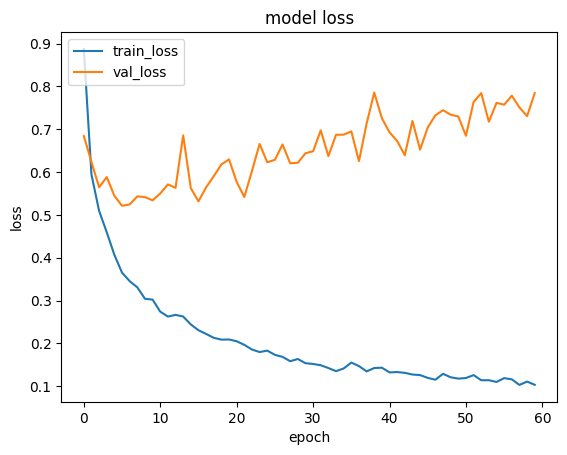

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'], loc='upper left')
plt.show()

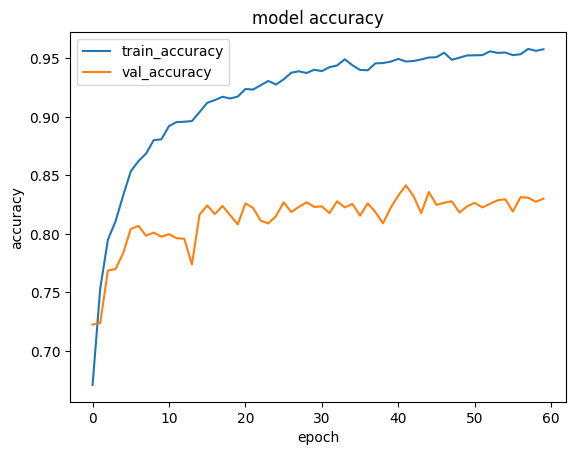

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'], loc='upper left')
plt.show()

In [33]:
from tensorflow.keras.models import load_model

# Path to the saved model
model_path = "/content/models/EfficientNetB4/EfficientNetB4.keras"

# Load the model
model = load_model(model_path)



In [31]:
test_image = cv2.imread("/content/4/Emotions Dataset/Emotions Dataset/test/happy/520857.jpg")
test_image = cv2.resize(test_image , (CONFIGURATION["IM_SIZE"] , CONFIGURATION["IM_SIZE"]))
im = tf.constant(test_image , dtype = tf.float32)
im = tf.expand_dims(im , axis = 0)
print(model(im))
print(CLASS_NAMES[tf.argmax(model(im) , axis = 1).numpy()[0]])

tf.Tensor([[4.674017e-15 1.000000e+00 3.156730e-14]], shape=(1, 3), dtype=float32)
happy
